# Modelling Approach
Here I selected only 2017 year for prediction of 15 days, so I will use DeterministicProcess and CalendarFourier to create:  
1)Indicators for weekly seasons;  
2)Linear order of trend;  
3)Fourier features of order 4 for monthly seasons.

**HYBRID MODELS**   
Linear regression excels at extrapolating trends, but can't learn interactions. Catboost excels at learning interactions, but can't   extrapolate trends. In the next codes, I'll create "hybrid" forecasters that combine complementary learning algorithms and let the strengths    of one make up for the weakness of the other.  

**COMPONENTS AND RESIDUALS**    
So that we can design effective hybrids, we need a better understanding of how time series are constructed. Many time series can be closely   described by an additive model of just three components (Seasons, trend, and cycles) plus some essentially unpredictable, entirely random error.
  

series = trend + seasons + cycles + error  
  

The residuals of a model are the difference between the target the model was trained on and the predictions the model makes.  
  
Add together all the components we learned and we get the complete model. This is essentially what linear regression would do if you trained   it on a complete set of features modeling trend, seasons, and cycles.

# **HYBRID FORCASTING WITH RESIDUALS**  

It's possible to use one algorithm for some of the components and another algorithm for the rest. This way we can always choose the best algorithm for each component. To do this, we use one algorithm to fit the original series and then the second algorithm to fit the residual series.

In detail, the process is this:

1. Train and predict with first model

model_1.fit(X_train_1, y_train)

y_pred_1 = model_1.predict(X_train)

2. Train and predict with second model on residuals

model_2.fit(X_train_2, y_train - y_pred_1)

y_pred_2 = model_2.predict(X_train_2)

3. Add to get overall predictions

y_pred = y_pred_1 + y_pred_2

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, mean_squared_error,mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
import unittest
from warnings import simplefilter
simplefilter('ignore')

In [2]:
# Function for mape metric
def mape(y_test, pred):
    y_test, pred = np.array(y_test), np.array(pred)
    mape = np.mean(np.abs((y_test - pred) / y_test))
    return mape

In [3]:
# Unit test, for checking shape of datasets before modelling
def test_answer(df1,df2):
    assert len(df1) == len(df2), "difference in shape"


In [4]:
## Set Plot Parameters
sns.set(color_codes=True)        
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)
plot_params = dict(color="0.75", style=".-", markeredgecolor="0.25", markerfacecolor="0.25", legend=False)

In [5]:
datafolder = '/Users/nurik/Documents/kaggle/store-sales-time-series-forecasting/' ## Path of datasets

## Train & Test Datasets
train=pd.read_csv(datafolder+'train.csv',parse_dates=['date'],
                  dtype={'store_nbr':'int8', 'family':'category', 'sales':'float32',
                        'onpromotion':'int16','id':'int32'} ,infer_datetime_format= True)


test=pd.read_csv(datafolder+'test.csv',parse_dates=['date'],
                 dtype={'store_nbr':'int8', 'family':'category','onpromotion':'int16','id':'int32'},
                 infer_datetime_format= True)

## Supplementary Datasets
oil=pd.read_csv(datafolder+'oil.csv',parse_dates=['date'], infer_datetime_format= True)
holidays_events=pd.read_csv(datafolder+'holidays_events.csv',parse_dates=['date'], infer_datetime_format= True)


In [6]:
print(f"Count dataset before cleaning dataset - {len(train)}")

Count dataset before cleaning dataset - 3000888


In [7]:
# handling the ouliers for each store, as we see in EDA Notebook
for i in range(1,len(train.store_nbr.unique())+1):
    val = train[train.store_nbr == i].sales.quantile(0.99)
    train = train.drop(train[(train.store_nbr==i) & (train.sales > val)].index)

In [8]:
print(f"Count dataset after cleaning dataset - {len(train)}")

Count dataset after cleaning dataset - 2970872


In [9]:
# To Evaluate our model, I will create validation dataset, with horizon - 15 days
valid = train[train['date']>='2017-08-01']
train = train[train['date']<'2017-08-01'] 

## Train Dataset conversion from large to wide 
## Because of prediction is for only 15 days, I'll use data from 2017 only
store_sales = train.drop('id',axis=1).set_index(['store_nbr','family','date'])
valid_sales = valid.drop('id',axis=1).set_index(['store_nbr','family','date'])

family_sales = store_sales.drop('onpromotion', axis=1).unstack(['store_nbr','family']).loc['2017']
family_sales.index = family_sales.index.to_period('D')

valid_family_sales = valid_sales.drop('onpromotion', axis=1).unstack(['store_nbr','family']).loc['2017']
valid_family_sales.index = valid_family_sales.index.to_period('D')

In [4]:
family_sales.head(5)

sales                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2017-01-01        0.0       0.0    0.0       0.0   0.0     0.000000   
2017-01-02        5.0       0.0    0.0    1434.0   0.0   166.819000   
2017-01-03        4.0       0.0    4.0    3081.0   2.0   519.348022   
2017-01-04        1.0       0.0    4.0    3039.0   2.0   543.250977   
2017-01-05        2.0       0.0    3.0    2617.0   0.0   533.479980   

                                                     ...            \
store_nbr                                            ...         9   
family     CELEBRATION CLEANING   DAIRY        DELI  ... MAGAZINES   
date                                                 ...             
2017-01-01         0.0      0.0     0.0    0.000000  ...       0.0   
2017-01-02         0.0    332.0   376.0   44.980000  ...       5.0   
2017-01-03        15.0    952.0  1045.0  209.300003  ...       2.0   
2017-01-04        17.0   1055.0  1029.0  135.944000  ...       3.0   
2017-01-05        40.0    918.0   853.0  137.005997  ...       2.0   

                                                                           \
store_nbr                                                                   
family           MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                        
2017-01-01    0.000000           0.0          0.0                     0.0   
2017-01-02  659.570007        1243.0         11.0                    41.0   
2017-01-03  547.364014         876.0          6.0                    15.0   
2017-01-04  395.287994         677.0          6.0                    13.0   
2017-01-05  470.768005         604.0          7.0                    10.0   

                                                                               \
store_nbr                                                                       
family         POULTRY PREPARED FOODS      PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                            
2017-01-01    0.000000       0.000000     0.000000                        0.0   
2017-01-02  843.596008     115.188995  3136.895996                        1.0   
2017-01-03  714.659973     133.039001  3229.558105                        1.0   
2017-01-04  536.830017      75.201004  1491.416992                        7.0   
2017-01-05  414.100006     113.698997  1566.821045                        1.0   

                    
store_nbr           
family     SEAFOOD  
date                
2017-01-01     0.0  
2017-01-02    23.0  
2017-01-03    14.0  
2017-01-04     0.0  
2017-01-05    17.0  

[5 rows x 1782 columns]

In [5]:
#DeterministicProcess and CalendarFourier
y = family_sales.loc(axis=1)['sales']
y_valid = valid_family_sales.loc(axis=1)['sales']
fourier = CalendarFourier(freq='M', order=4) ## Fourier features of order 4 for monthly seasons
dp =  DeterministicProcess(index = y.index, seasonal = True,  
                          order = 1, additional_terms = [fourier], drop = True)
X_train_1 = dp.in_sample()

X_valid_1 = dp.out_of_sample(steps = 15) # 15 because we are predicting next 15 days

In [6]:
## Drop Transferred & Workday Holidays
holidays_events= holidays_events.loc[(holidays_events.transferred==False) & (holidays_events.type != 'Work Day') & (holidays_events.locale != 'Local')]

## Drop Duplicated Holiday Days:
holidays_events.drop_duplicates('date', inplace=True)
holidays_events = holidays_events[['date','type']] ## Keep date & holiday type for merging

## Merging and Mapping:
X_train_1.index = X_train_1.index.to_timestamp()
X_train_1=X_train_1.reset_index().merge(holidays_events,on='date',how='left')
X_train_1.rename({'type':'is_holiday'}, axis=1, inplace=True)
X_train_1['is_holiday']=X_train_1.is_holiday.map({'Holiday':1, 'Transfer':1, 'Additional':1,
                                                      'Bridge':1, 'Event':1})
X_train_1['is_holiday']=X_train_1['is_holiday'].fillna(0).astype('int8')

## Adding weekends to holiday as well
X_train_1['day_of_week'] = X_train_1.date.dt.day_of_week.astype('int8')
X_train_1.loc[(X_train_1['day_of_week']==5) | (X_train_1['day_of_week']==6), 'is_holiday'] = 1
X_train_1.drop('day_of_week',axis=1, inplace=True)

## Removing the first day of a year from holidays.
X_train_1['start_of_year']= (X_train_1.date.dt.dayofyear ==1)
X_train_1.loc[X_train_1['start_of_year']==True, 'is_holiday']=0
X_train_1['start_of_year'] = X_train_1['start_of_year'].astype('int8')

X_train_1 = X_train_1.set_index('date')
X_train_1.index = X_train_1.index.to_period('D')

In [7]:
# Same for validation dataset
X_valid_1.index = X_valid_1.index.rename('date').to_timestamp()
## Merging and Mapping:
X_valid_1=X_valid_1.reset_index().merge(holidays_events,on='date',how='left').set_index('date')
X_valid_1.rename({'type':'is_holiday'}, axis=1, inplace=True)
X_valid_1['is_holiday']=X_valid_1.is_holiday.map({'Holiday':1, 'Transfer':1, 'Additional':1,
                                                      'Bridge':1, 'Event':1})
X_valid_1['is_holiday']=X_valid_1['is_holiday'].fillna(0).astype('int8')

## Adding weekends to holiday as well
X_valid_1['day_of_week'] = X_valid_1.index.day_of_week.astype('int8')
X_valid_1.loc[(X_valid_1['day_of_week']==5) | (X_valid_1['day_of_week']==6), 'is_holiday'] = 1
X_valid_1.drop('day_of_week',axis=1, inplace=True)

## Removing the first day of a year from holidays as mentioned before Favorita is closed these days.
X_valid_1['start_of_year']= (X_valid_1.index.dayofyear ==1)
X_valid_1.loc[X_valid_1['start_of_year']==True, 'is_holiday']=0
X_valid_1['start_of_year'] = X_valid_1['start_of_year'].astype('int8')
X_valid_1.index = X_valid_1.index.to_period('D')

In [8]:
# ML Modelling
def fit(model_1, model_2, X_train_1, X_train_2, y):

    """
    Defination for hyprid models fitting.
    Inputs: 
    -   modeal_1: the 1st model.
    -   model_2: the 2nd model.
    -   X_train_1: training data for model_1.
    -   X_train_2: trainng data fro model_2.
    -   y: target of training data of model_1.
    Output:
    -   Hyprid models fitting.
    """
    
    model_1.fit(X_train_1,y)

    # Make predictions with model_1
    y_fit = pd.DataFrame(model_1.predict(X_train_1), index=X_train_1.index, columns=y.columns)

    y_resid = y - y_fit # compute residuals
    y_resid = y_resid.unstack().reset_index(['store_nbr','family','date']) # wide to long
    y_resid['date'] = y_resid['date'].dt.to_timestamp()
    y_resid = y_resid.set_index(['store_nbr','family','date'])
    y_resid.rename({0:'residuals'},axis=1,inplace=True)
    
    # re-order the index of y_resid as the index of X_train_2
    new_index=X_train_2.copy()
    new_index['family']=le.inverse_transform(new_index['family']) # inverse transform label encoder for family
    new_index=new_index.reset_index().set_index(['store_nbr','family','date'])
    y_resid = y_resid.reindex(new_index.index)
    
    y_resid.reset_index(['store_nbr','family'], drop=True, inplace=True) # drop unneccessary varibales
    
    model_2.fit(X_train_2, y_resid)

def predict(model_1, model_2, X_train_1, X_train_2):
    
    """
    Defination for hyprid models prediction.
    Inputs: 
    -   modeal_1: the 1st model (fiited).
    -   model_2: the 2nd model (fiited).
    -   X_train_1: training data for model_1.
    -   X_train_2: trainng data fro model_2.
    Output:
    -   y_pred: final prediction of hyprid models.
    """
    
    global y 
    y_pred = pd.DataFrame(model_1.predict(X_train_1), index=X_train_1.index, columns=y.columns) # prediction of 1st model

    y_pred = y_pred.unstack().reset_index(['store_nbr','family','date']) # wide to long
    y_pred['date'] = y_pred['date'].dt.to_timestamp()
    y_pred = y_pred.set_index(['store_nbr','family','date'])
    y_pred.rename({0:'sales'},axis=1,inplace=True)
    
    # re-order the index of y_pred as the index of X_train_2
    new_index=X_train_2.copy()
    new_index['family']=le.inverse_transform(new_index['family']) # inverse transform label encoder for family
    new_index=new_index.reset_index().set_index(['store_nbr','family','date'])
    y_pred = y_pred.reindex(new_index.index)
    
    values = y_pred['sales'].values
    sales = model_2.predict(X_train_2) + values
    y_pred['sales'] = sales.clip(0.0)  ## clipping values < 0 to 0.0
    
    return y_pred 

In [39]:
# Unit test, checking shape of X and y.
test_answer(X_train_1,y)

In [9]:
model_1 = LinearRegression() 

model_2 = CatBoostRegressor(silent= True) ## by default hyperparameter

# X_train_2: Features for CatBoost
X_train_2 = train.drop(['id','sales'],axis=1).set_index('date').loc['2017']
X_valid_2 = valid.drop(['id','sales'],axis=1).set_index('date')
# Label encoding for 'family'
le = LabelEncoder()
X_train_2['family'] = le.fit_transform(X_train_2['family'])
X_valid_2['family'] = le.transform(X_valid_2['family'])

X_train_2['start_of_year']= (X_train_2.index.dayofyear ==1).astype('int8')
X_valid_2['start_of_year']= (X_valid_2.index.dayofyear ==1).astype('int8')

fit(model_1, model_2, X_train_1, X_train_2, y)

y_pred= predict(model_1, model_2, X_valid_1, X_valid_2)

In [10]:
X_valid_2.head(5)

store_nbr  family  onpromotion  start_of_year
date                                                     
2017-08-01          1       0            0              0
2017-08-01          1       1            0              0
2017-08-01          1       2            0              0
2017-08-01          1       3           26              0
2017-08-01          1       4            0              0

In [11]:
X_valid_1.head(5)

trend  s(1,7)  s(2,7)  s(3,7)  s(4,7)  s(5,7)  s(6,7)  s(7,7)  \
date                                                                        
2017-08-01  213.0     0.0     0.0     1.0     0.0     0.0     0.0     0.0   
2017-08-02  214.0     0.0     0.0     0.0     1.0     0.0     0.0     0.0   
2017-08-03  215.0     0.0     0.0     0.0     0.0     1.0     0.0     0.0   
2017-08-04  216.0     0.0     0.0     0.0     0.0     0.0     1.0     0.0   
2017-08-05  217.0     0.0     0.0     0.0     0.0     0.0     0.0     1.0   

            sin(1,freq=M)  cos(1,freq=M)  sin(2,freq=M)  cos(2,freq=M)  \
date                                                                     
2017-08-01       0.000000       1.000000       0.000000       1.000000   
2017-08-02       0.201299       0.979530       0.394356       0.918958   
2017-08-03       0.394356       0.918958       0.724793       0.688967   
2017-08-04       0.571268       0.820763       0.937752       0.347305   
2017-08-05       0.724793       0.688967       0.998717      -0.050649   

            sin(3,freq=M)  cos(3,freq=M)  sin(4,freq=M)  cos(4,freq=M)  \
date                                                                     
2017-08-01       0.000000       1.000000       0.000000       1.000000   
2017-08-02       0.571268       0.820763       0.724793       0.688967   
2017-08-03       0.937752       0.347305       0.998717      -0.050649   
2017-08-04       0.968077      -0.250653       0.651372      -0.758758   
2017-08-05       0.651372      -0.758758      -0.101168      -0.994869   

            is_holiday  start_of_year  
date                                   
2017-08-01           0              0  
2017-08-02           0              0  
2017-08-03           0              0  
2017-08-04           0              0  
2017-08-05           1              0

# **HYPER MODELS EVALUATION**

We can look to the diagram of the true average sales vs. the predicted ones, as determine if our hyper models doing well or not.

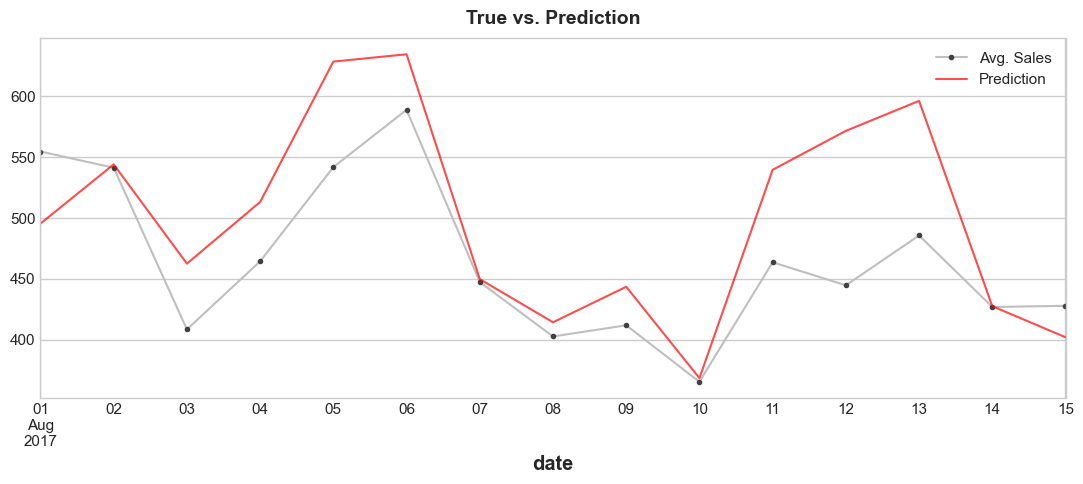

In [12]:
ax=y_valid.mean(axis=1).plot(**plot_params, label='Avg. Sales', title='True vs. Prediction')
ax=y_pred.groupby('date')['sales'].mean().plot(color='red', alpha=0.7, label='Prediction', legend=True)
ax=plt.legend()
plt.show()

# Metrics MAE and MAPE

In [18]:
mae_metr = mean_absolute_error(y_valid.mean(axis=1),y_pred.groupby('date')['sales'].mean())
print(f"MAE in validation set - {mae_metr}")

MAE in validation set - 45.723815751542446


In [22]:
mape_metr = mape(y_valid.mean(axis=1),y_pred.groupby('date')['sales'].mean())
print(f"MAPE in validation set - {round(mape_metr*100,2)}%")

MAPE in validation set - 9.63%


# Next steps
If everyone will fine with our metric, we need to wrap all steps in functions(data extracting, data proccessing, data cleaning, data modelling) and set it on cron in virtual machine, or if we can use cloud technologies and set our script to Instances.